# Moving Window Spectrogram Analysis

Borrows some work from playground_plasma_data notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, linalg, stats
from sklearn.metrics import pairwise

from plasma_data_handler import PlasmaDataHandler

In [2]:
class MovingWindow:
    """
    """
    def __init__(self, data_handler, window_length, step_size):
        """
        Class to perform a moving SVD analysis of the spectrograms from data_handler.
        
        Parameters
        ----------
        data_handler : PlasmaDataHandler class
            Source of spectrograms
        window_length : int
            How many columns of the spectrogram to use in an SVD
        step_size : int
            How many columns between the beginning of one window to the next.
        """
        self.data_handler = data_handler
        self.window_length = self.isAtLeastOne(window_length)
        self.step_size = self.isAtLeastOne(step_size)
    
    @staticmethod
    def isAtLeastOne(value):
        if value >= 1:
            return int(value)
        return 1

    @staticmethod
    def omega(matrix):
        """
        Approximate threshold for separating signal from noise in an SVD.

        follows http://www.pyrunner.com/weblog/2016/08/01/optimal-svht/ 

        Parameters
        ----------
        matrix : ndarray
            matrix to be SVD'd

        Returns
        -------
        float
        """
        beta = min(matrix.shape) / max(matrix.shape)
        coef = [0.56, -0.95, 1.82, 1.43]
        poly = [beta ** (3 - n) for n in range(4)]
        return sum([c*p for c,p in zip(coef, poly)]);

    @staticmethod
    def computeSignal(u, s, vh, test, t_star):
        """
        Computes the signal part of the SVD.

        Parameters
        ----------
        u : ndarray
            Left singular matrix
        s : ndarray
            Singular values
        vh : ndarray
            Right singular matrix
        test : ndarray
            The array of test points.
        t_star : float
            The singular value threshold.

        Returns
        -------
        ndarray shaped like test
        """
        out = np.zeros_like(test, dtype=float)
        for idx, truth in enumerate(s > t_star):
            if truth:
                u1 = u[:, idx]
                v1 = vh[idx, :]
                s1 = s[idx]
                out += np.mean(v1) * s1 *  np.tile(u1, (test.shape[1],1)).T
        return out
    
    @staticmethod
    def scaleMinMax(minimum, maximum, scale):
        """
        Rescales minimum and maximum to be scale times smaller.  If minimum is
        positive it is not changed.  Used for adjusting colormaps.

        Parameters
        ----------
        minimum : float
            The minimum value in the colormap.
        maximum : float
            The maximum value in the colormap.
        scale : float
            The scale to change to.  (0,1.0]

        Returns
        -------
        Two floats, vmin and vmax for matplotlib's imshow
        """
        if maximum == minimum:  # all zeros, I guess.
            return 0, 1  # arbitrary
        if maximum <= 0 or minimum >= 0:
            return minimum, scale * maximum
        # should be max > 0 and min < 0 now
        return scale * minimum, scale * maximum
    
    def computeSVD(self, matrix, dd, n_singular=None):
        """
        Computes the SVD of matrix and applied the omega signal threshold.
        
        Parameters
        ----------
        matrix : ndarray
            Matrix to be SVD'd
        dd : dict
            Dictionary to update
        n_singular : int / None
            How many singular values to keep.  If None, use the Omega formula to decide.
            
        Returns
        -------
        dd, updated
        """
        u, s, vh = np.linalg.svd(matrix, full_matrices = False)
        med_sv = np.median(s)
        t_star = self.omega(matrix) * med_sv
        n_signal = (s > t_star).sum()
        if n_singular is None:
            n_singular = n_signal
        
        dd.update({'n_signal': n_signal,
                   'us'   : u[:, :n_singular],
                   'sings': s[:n_singular],
                   'vs'   : vh[:n_singular, :]
                 })
        return dd
        
    
    def runMovingSVD(self, instrument, channel, ft_size, n_singular=None):
        """
        Aggregator for yieldMovingSVD.  See there for parameter values.
        
        Returns
        -------
        dict of generator dicts
        """
        window_svds = {}  # store the SVD results
        
        generator = self.yieldMovingSVD(instrument, channel, ft_size, n_singular)
        for idx, res in enumerate(generator):
            window_svds[idx] = res
            
        return window_svds
    
    def yieldMovingSVD(self, instrument, channel, ft_size, n_singular=None):
        """
        Performs the moving window SVD on a spectrogram of the data from channel of instrument.
        
        Parameters
        ----------
        instrument : str
            'ECE' or 'BES'
        channel : int
            if 'ECE' between 1 and 40
            if 'BES' between 1 and 64
        ft_size : int
            The number of readings to use to perform the Fourier transform
        n_singular : int / None
            How many singular values to keep.  If None, use the Omega formula to decide.
            
            
        Returns
        -------
        dict of results for each step
        """
        # spectrogram (freqs, time steps)
        a = self.data_handler.createSpectrogram(instrument, channel, ft_size, False)
        n_windows = 1 + (a.shape[1] - self.window_length) // self.step_size
        
        window_svds = {}  # store the SVD results
        
        for step in range(n_windows):
            start = step * self.step_size
            stop = self.window_length + start
            matrix = a[:, start:stop]
            dd = {'start': start,  # inclusive in the usual pythonic way
                  'stop' : stop,   # exclusive in the usual pythonic way
                 }
            
            dd = self.computeSVD(matrix, dd, n_singular)

            yield dd
            
    def makeFeaturePlot(self, instrument, channel, ft_size, n_singular):
        """
        Creates a plot of the results from yieldMovingSVD.  Parameters mirror that method
        except n_singular must be given.
        """
        _, ts = self.data_handler.returnCoincidentData(instrument, channel)
        a = self.data_handler.createSpectrogram(instrument, channel, ft_size, False)
        fig, axs = plt.subplots(n_singular + 1, 1, sharex=True, figsize=(12,10))
        
        vmin, vmax = self.scaleMinMax(np.min(a), np.max(a), 0.5)
        axs[0].imshow(a, origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
        title_str = ('{:s}, '
                     'channel {:d}, '
                     'ft_size {:d}, '
                     'SVD Batch {:d} / Step {:d}').format(instrument,
                                                        channel,
                                                        ft_size,
                                                        self.window_length,
                                                        self.step_size)
        axs[0].set_title(title_str, fontsize=16)
        
        max_idx = (ft_size - 1) // 2
        max_freq = np.fft.fftfreq(ft_size, d=ts * 1e-3)[max_idx]  # kHz
        yticks = ['{:.1f}'.format(tick) for tick in
                  np.linspace(0, max_freq, 5, endpoint=True)]
        axs[0].set_yticks(np.linspace(0, max_idx, 5, endpoint=True))
        axs[0].set_yticklabels(yticks)
        axs[0].set_ylabel('f (kHz)', fontsize=14)
        
        colors = ['r', 'g', 'b', 'c', 'm']  # colors for different time segments
        
        generator = self.yieldMovingSVD(instrument, channel, ft_size, n_singular)
        for cdx, r in enumerate(generator):
            col = colors[cdx % len(colors)]
            x1 = list(range(r['start'], r['stop']))
            for idx in range(n_singular):
                v1 = r['vs'][idx, :]
                v1 *= np.sign(r['us'][0, 0])  # keeps the signs of the vs consistent
                ax = axs[idx + 1]
                ax.plot(x1, v1, '-', color=col)
                
        # add the x label stuff to the last axis
        ax.set_xlabel('time (ms)', fontsize=14)
        ax.set_xticks(np.linspace(0, a.shape[1], 5, endpoint=True))
        ax.set_xticklabels(np.linspace(0, a.shape[1] * ft_size, 5,
                                       endpoint=True) * ts / 1000.0,
                           fontsize=12)

        for idx, ax in enumerate(axs[1:]):
            ax.set_ylabel(r'v$_{:d}$'.format(idx + 1), fontsize=14)
        
        plt.show()
            

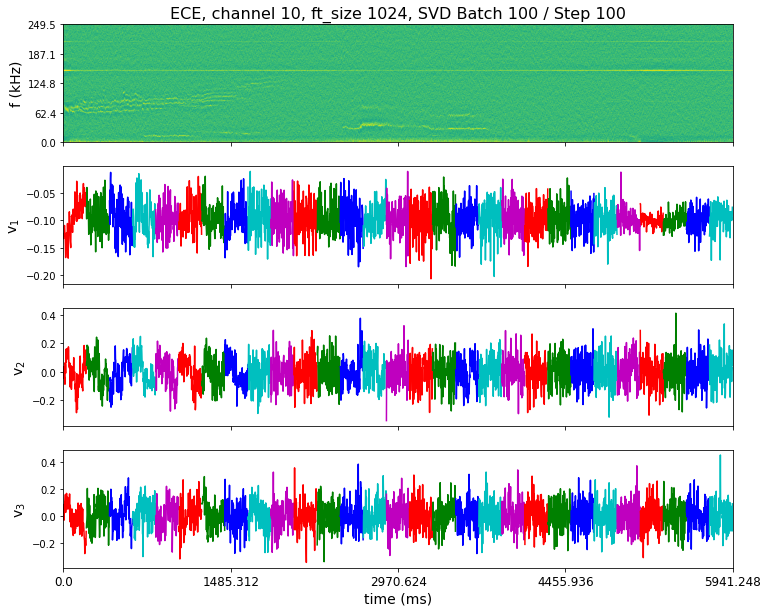

In [3]:
n_sing = 3
instr = 'ECE'
channel = 10
window_size = 1024
dh = PlasmaDataHandler('shot_180625.h5')
t = MovingWindow(dh, 100, 100)
t.makeFeaturePlot(instr, channel, window_size, n_sing)